In [6]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,d4ef06c8-d272-4774-826c-4a13bbb12d8a,kernel_linear_regression,Transformer,basis_dim=2,-1,-1,5,12,8,kernel_linear_regression_toy


In [10]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "d4ef06c8-d272-4774-826c-4a13bbb12d8a"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

{'standard': {'task_name': 'kernel_linear_regression', 'n_dims': 5, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard'}}


100%|██████████| 1/1 [00:00<00:00, 47662.55it/s]


# Plot pre-computed metrics

In [11]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
print(models)
print(metrics)
print(metrics)
print(conf)
basic_plot(metrics["standard"], models=models)
plt.show()

kernel_linear_regression_toy d4ef06c8-d272-4774-826c-4a13bbb12d8a
{'standard': {'task_name': 'kernel_linear_regression', 'n_dims': 5, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard'}}


100%|██████████| 1/1 [00:00<00:00, 59074.70it/s]

{'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [21.140798568725586, 17.793275833129883, 13.739712715148926, 12.69067668914795, 11.674221992492676, 9.221728324890137, 6.378802299499512, 5.038470268249512, 3.748842716217041, 2.0556230545043945, 0.7140204906463623, 0.37719225883483887, 0.2786880135536194, 0.12278957664966583, 0.1063966304063797, 0.08275987207889557, 0.08113399893045425, 0.05431278422474861, 0.05513417720794678, 0.04750237613916397, 0.05762939527630806], 'std': [54.51422882080078, 43.02679443359375, 36.82685470581055, 38.921382904052734, 31.729074478149414, 30.5369815826416, 14.9363374710083, 13.204437255859375, 13.72874927520752, 7.530749320983887, 2.92968487739563, 2.019282579421997, 1.9705621004104614, 0.48266366124153137, 0.46272748708724976, 0.29210183024406433, 0.27096083760261536, 0.2148911952972412, 0.1694018840789795, 0.15337127447128296, 0.20455841720104218], 'bootstrap_low': [18.68714714050293, 15.854154586791992, 12.117189407348633, 10.977110862731934,

KeyError: 'kernel_linear_regression'

In [33]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [34]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [35]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [36]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [37]:
with torch.no_grad():
    pred = model(xs, ys)

5


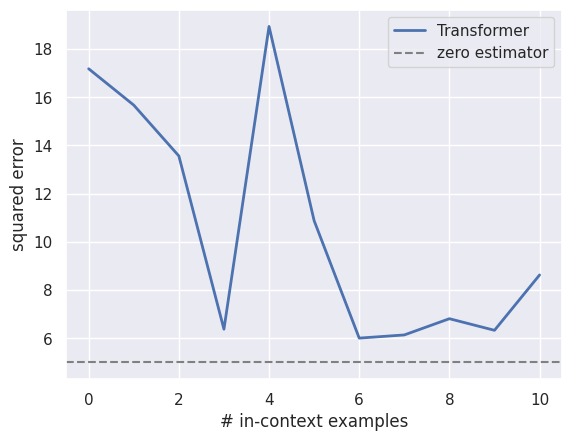

In [42]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "kernel_linear_regression": n_dims,
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]
plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [43]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

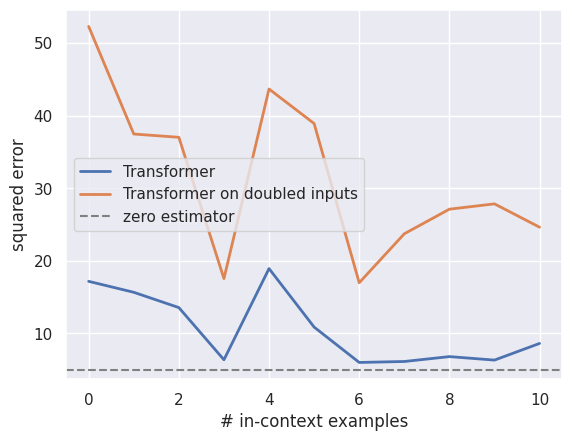

In [44]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.